In [1]:
from os import listdir
from os.path import isdir, join
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

In [2]:
# Create list of all targets (minus background noise)
dataset_path = '.\\data_speech_commands_v0.02'
all_targets = all_targets = [name for name in listdir(dataset_path) if isdir(join(dataset_path, name))]
all_targets.remove('_background_noise_')
print(all_targets), len(all_targets)

['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']


(None, 35)

In [3]:
# Settings
feature_sets_path = '.\\'
feature_sets_filename = 'all_targets_mfcc_sets.npz'
model_filename = 'commands_model.h5'

In [4]:
# Load feature sets
feature_sets = np.load(join(feature_sets_path, feature_sets_filename))
print(feature_sets.files)

['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']


In [5]:
# Assign feature sets
x_train = feature_sets['x_train']
y_train = feature_sets['y_train']
x_val = feature_sets['x_val']
y_val = feature_sets['y_val']
x_test = feature_sets['x_test']
y_test = feature_sets['y_test']

In [6]:
# Look at tensor dimensions
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(77486, 26, 16)
(9710, 26, 16)
(9660, 26, 16)


In [7]:
# Peek at labels
print(y_val)

[33. 10.  8. ... 10. 18. 29.]


In [8]:
# View the dimensions of our input data
print(x_train.shape)

(77486, 26, 16)


In [9]:
# CNN for TF expects (batch, height, width, channels)
# So we reshape the input tensors with a "color" channel of 1
x_train = x_train.reshape(x_train.shape[0], 
                          x_train.shape[1], 
                          x_train.shape[2], 
                          1)
x_val = x_val.reshape(x_val.shape[0], 
                      x_val.shape[1], 
                      x_val.shape[2], 
                      1)
x_test = x_test.reshape(x_test.shape[0], 
                        x_test.shape[1], 
                        x_test.shape[2], 
                        1)
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(77486, 26, 16, 1)
(9710, 26, 16, 1)
(9660, 26, 16, 1)


In [10]:
# Input shape for CNN is size of MFCC of 1 sample
sample_shape = x_test.shape[1:]
print(sample_shape)

(26, 16, 1)


In [24]:
# Build model
model = models.Sequential()
model.add(layers.Conv2D(32, 
                        (2, 2), 
                        activation='relu',
                        input_shape=sample_shape))

model.add(layers.Conv2D(32, (2, 2), activation='relu', padding="SAME"))

model.add(layers.Conv2D(64, (2, 2), activation='relu', padding="SAME", kernel_regularizer=tf.keras.regularizers.l1(l = 0.0001)))

model.add(layers.Conv2D(128, (2, 2), activation='relu', padding="SAME", kernel_regularizer=tf.keras.regularizers.l1(l = 0.0001)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Classifier
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(all_targets), activation='softmax'))

In [25]:
# Display model
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 25, 15, 32)        160       
                                                                 
 conv2d_11 (Conv2D)          (None, 25, 15, 32)        4128      
                                                                 
 conv2d_12 (Conv2D)          (None, 25, 15, 64)        8256      
                                                                 
 conv2d_13 (Conv2D)          (None, 25, 15, 128)       32896     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 12, 7, 128)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 10752)             0         
                                                      

In [26]:
# Add training parameters to model
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', 
              metrics=['acc'])

In [27]:
# Train
history = model.fit(x_train, 
                    y_train, 
                    epochs=10, 
                    batch_size=100, 
                    validation_data=(x_val, y_val))

Epoch 1/10
775/775 [==============================] - 65s 82ms/step - loss: 2.3685 - acc: 0.3521 - val_loss: 1.1171 - val_acc: 0.7042
Epoch 2/10
775/775 [==============================] - 63s 81ms/step - loss: 1.2680 - acc: 0.6544 - val_loss: 0.7866 - val_acc: 0.7944
Epoch 3/10
775/775 [==============================] - 62s 80ms/step - loss: 0.9759 - acc: 0.7415 - val_loss: 0.7107 - val_acc: 0.8160
Epoch 4/10
775/775 [==============================] - 63s 81ms/step - loss: 0.8240 - acc: 0.7865 - val_loss: 0.6618 - val_acc: 0.8337
Epoch 5/10
775/775 [==============================] - 62s 81ms/step - loss: 0.7174 - acc: 0.8171 - val_loss: 0.6113 - val_acc: 0.8516
Epoch 6/10
775/775 [==============================] - 63s 81ms/step - loss: 0.6423 - acc: 0.8380 - val_loss: 0.5885 - val_acc: 0.8597
Epoch 7/10
775/775 [==============================] - 62s 80ms/step - loss: 0.5879 - acc: 0.8558 - val_loss: 0.5836 - val_acc: 0.8622
Epoch 8/10
775/775 [==============================] - 63s 81ms

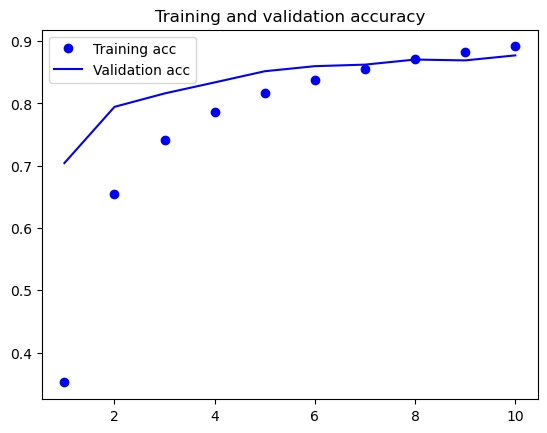

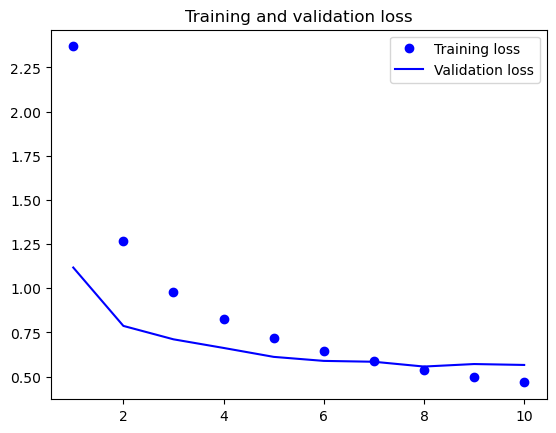

In [28]:
# Plot results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [29]:
# Save the model as a file
models.save_model(model, model_filename)

In [31]:
# TEST: Load model and run it against test set
saved_model = models.load_model(model_filename)
for i in range(90, 100):
    print('Answer:', y_test[-i], ' Prediction:', int(tf.math.argmax(saved_model.predict(np.expand_dims(x_test[-i], 0))[0])))

1/1 [==============================] - 0s 199ms/step
Answer: 22.0  Prediction: 22
1/1 [==============================] - 0s 24ms/step
Answer: 3.0  Prediction: 3
1/1 [==============================] - 0s 38ms/step
Answer: 17.0  Prediction: 17
1/1 [==============================] - 0s 32ms/step
Answer: 19.0  Prediction: 19
1/1 [==============================] - 0s 30ms/step
Answer: 34.0  Prediction: 34
1/1 [==============================] - 0s 32ms/step
Answer: 1.0  Prediction: 17
1/1 [==============================] - 0s 39ms/step
Answer: 11.0  Prediction: 18
1/1 [==============================] - 0s 31ms/step
Answer: 4.0  Prediction: 4
1/1 [==============================] - 0s 39ms/step
Answer: 19.0  Prediction: 19
1/1 [==============================] - 0s 36ms/step
Answer: 18.0  Prediction: 18


In [32]:
# Evaluate model with test set
saved_model.evaluate(x=x_test, y=y_test)

302/302 [==============================] - 4s 11ms/step - loss: 0.5801 - acc: 0.8696


[0.5801172256469727, 0.8695651888847351]